<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/seblock3_50epoch_flower_D_se_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.0 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 229MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf, se = True )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, se = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, se = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:48<00:00,  2.14it/s]


epoch: 0, lossD:0.793690443436787, lossG:11.953195372831475,lossG_fake:8.262069493966194, lossG_real:3.6911258675809044 ,equality:4.57094362638529


evaluate:122.97792053222656,kid_mean:0.07894439995288849, kid_std:0.01876477710902691,kid_:(tensor(0.0789), tensor(0.0188))


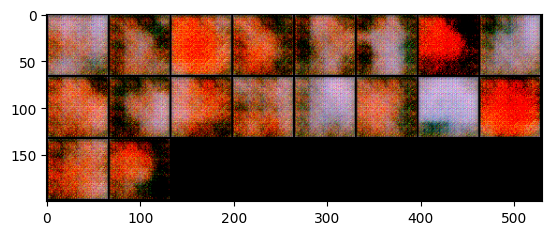

100%|██████████| 103/103 [00:09<00:00, 10.80it/s]


epoch: 1, lossD:0.6339474720066612, lossG:6.837755744897046,lossG_fake:3.9294203571902897, lossG_real:2.9083353929149296 ,equality:1.02108496427536


evaluate:123.67308044433594,kid_mean:0.08503773808479309, kid_std:0.03303486853837967,kid_:(tensor(0.0850), tensor(0.0330))


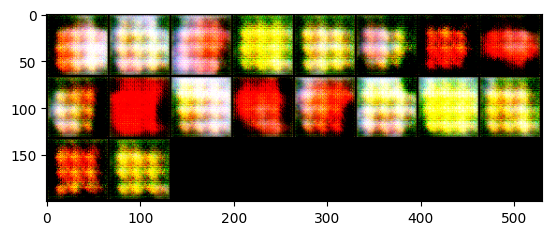

100%|██████████| 103/103 [00:09<00:00, 10.79it/s]


epoch: 2, lossD:0.9537687940360273, lossG:6.020368548272883,lossG_fake:3.526770046613749, lossG_real:2.493598510628765 ,equality:1.0331715359849838


evaluate:122.7540283203125,kid_mean:0.08423057198524475, kid_std:0.04026983678340912,kid_:(tensor(0.0842), tensor(0.0403))


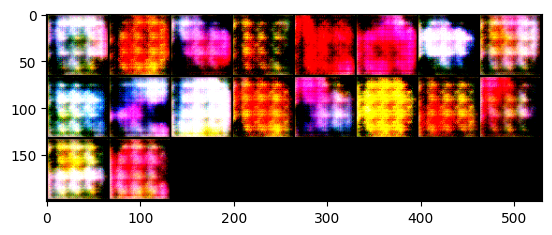

100%|██████████| 103/103 [00:09<00:00, 10.77it/s]


epoch: 3, lossD:1.0085468625342382, lossG:6.197697782979428,lossG_fake:3.7659350552605195, lossG_real:2.4317627450794848 ,equality:1.3341723101810348


evaluate:118.34841918945312,kid_mean:0.07645194977521896, kid_std:0.03506825864315033,kid_:(tensor(0.0765), tensor(0.0351))


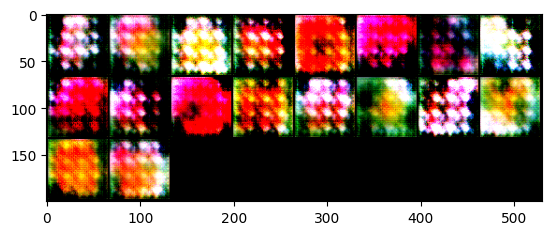

100%|██████████| 103/103 [00:09<00:00, 11.04it/s]


epoch: 4, lossD:0.9859365710934389, lossG:6.1716467755512125,lossG_fake:3.705626351162068, lossG_real:2.4660204252571734 ,equality:1.2396059259048946


evaluate:115.45808410644531,kid_mean:0.07705941796302795, kid_std:0.03661732003092766,kid_:(tensor(0.0771), tensor(0.0366))


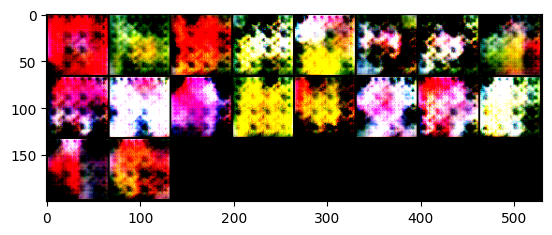

100%|██████████| 103/103 [00:09<00:00, 10.70it/s]


epoch: 5, lossD:0.9122131565242138, lossG:6.102771124793488,lossG_fake:3.686808991200716, lossG_real:2.415962139379631 ,equality:1.270846851821085


evaluate:122.76691436767578,kid_mean:0.08403194695711136, kid_std:0.0425955131649971,kid_:(tensor(0.0840), tensor(0.0426))


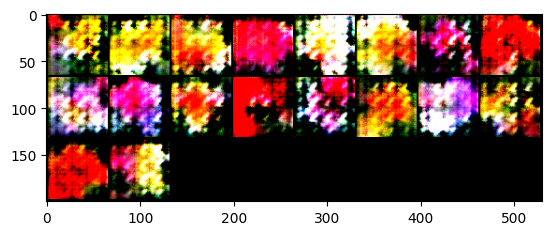

100%|██████████| 103/103 [00:09<00:00, 10.61it/s]


epoch: 6, lossD:0.9854758156156077, lossG:5.8511072223626295,lossG_fake:3.526783693183973, lossG_real:2.3243235511687197 ,equality:1.2024601420152532


evaluate:127.31792449951172,kid_mean:0.08884891867637634, kid_std:0.040234316140413284,kid_:(tensor(0.0888), tensor(0.0402))


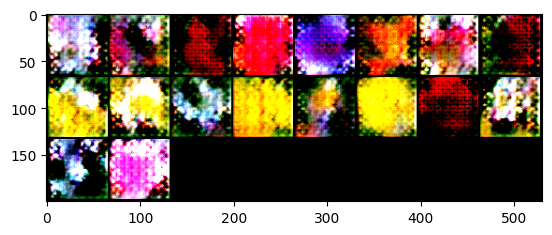

100%|██████████| 103/103 [00:09<00:00, 10.81it/s]


epoch: 7, lossD:0.9219241940859452, lossG:5.820598917100036,lossG_fake:3.4313091525753725, lossG_real:2.389289771468894 ,equality:1.0420193811064786


evaluate:115.63196563720703,kid_mean:0.07840419560670853, kid_std:0.0379679799079895,kid_:(tensor(0.0784), tensor(0.0380))


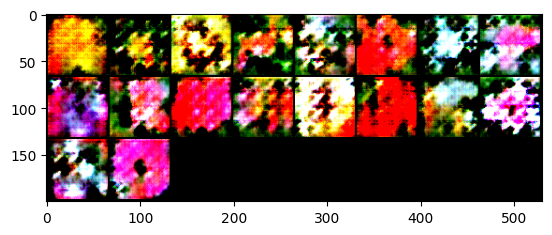

100%|██████████| 103/103 [00:09<00:00, 10.96it/s]


epoch: 8, lossD:0.8783544226757531, lossG:5.8167721368734115,lossG_fake:3.3893274479699365, lossG_real:2.427444662862611 ,equality:0.9618827851073255


evaluate:114.49476623535156,kid_mean:0.07909280806779861, kid_std:0.04319002106785774,kid_:(tensor(0.0791), tensor(0.0432))


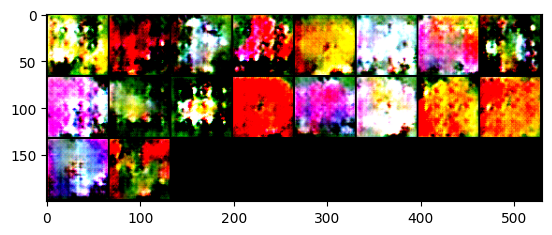

100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


epoch: 9, lossD:1.0064168644761575, lossG:5.557958774196291,lossG_fake:3.246457572122222, lossG_real:2.311501189921666 ,equality:0.9349563822005558


evaluate:119.05006408691406,kid_mean:0.08633852005004883, kid_std:0.03813823685050011,kid_:(tensor(0.0863), tensor(0.0381))


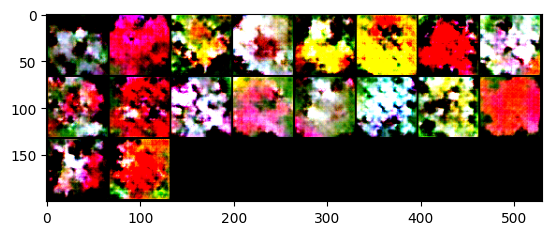

100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


epoch: 10, lossD:1.1390880994426393, lossG:5.1192554547948745,lossG_fake:2.944378159578564, lossG_real:2.1748773033179125 ,equality:0.7695008562606516


evaluate:115.16415405273438,kid_mean:0.08525722473859787, kid_std:0.03943885490298271,kid_:(tensor(0.0853), tensor(0.0394))


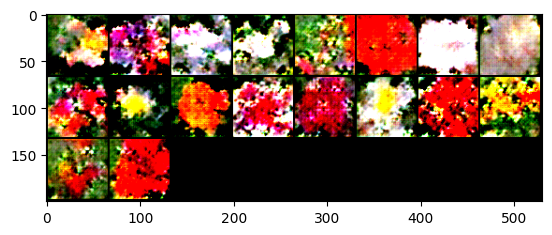

100%|██████████| 103/103 [00:09<00:00, 10.90it/s]


epoch: 11, lossD:1.0204740881341174, lossG:5.255393690275914,lossG_fake:2.9596286497069793, lossG_real:2.2957650284165316 ,equality:0.6638636212904476


evaluate:105.54138946533203,kid_mean:0.0768715888261795, kid_std:0.04046250134706497,kid_:(tensor(0.0769), tensor(0.0405))


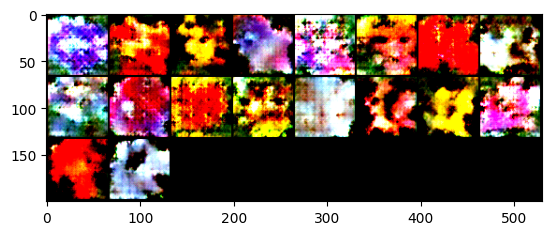

100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


epoch: 12, lossD:1.0896956136504423, lossG:5.267134708108254,lossG_fake:3.0130987850207727, lossG_real:2.2540359086203345 ,equality:0.7590628764004381


evaluate:106.3538818359375,kid_mean:0.08514279127120972, kid_std:0.04582973197102547,kid_:(tensor(0.0851), tensor(0.0458))


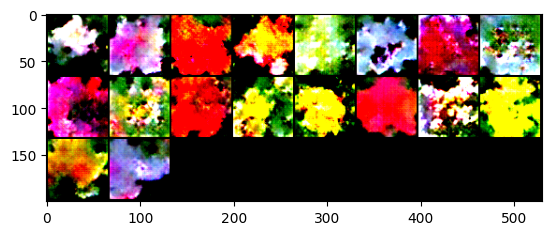

100%|██████████| 103/103 [00:09<00:00, 10.68it/s]


epoch: 13, lossD:1.021348166234285, lossG:5.2470388088411495,lossG_fake:2.9204475682915993, lossG_real:2.32659122376766 ,equality:0.5938563445239393


evaluate:99.88457489013672,kid_mean:0.07773388177156448, kid_std:0.04192708432674408,kid_:(tensor(0.0777), tensor(0.0419))


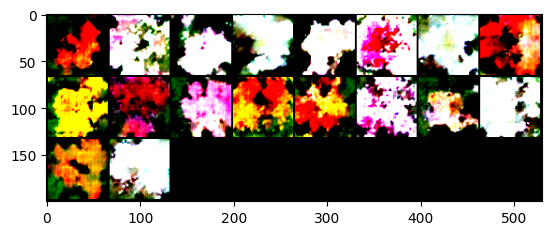

100%|██████████| 103/103 [00:09<00:00, 10.66it/s]


epoch: 14, lossD:0.9774165547009811, lossG:5.299088473458892,lossG_fake:2.993370303829897, lossG_real:2.3057181499536754 ,equality:0.6876521538762215


evaluate:98.8448486328125,kid_mean:0.07255754619836807, kid_std:0.03961046412587166,kid_:(tensor(0.0726), tensor(0.0396))


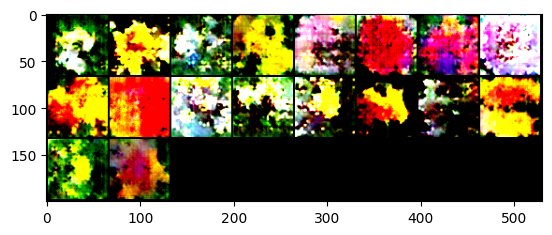

100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


epoch: 15, lossD:0.9570240395740398, lossG:5.339087217756846,lossG_fake:2.9315876694558893, lossG_real:2.4074995702910194 ,equality:0.52408809916487


evaluate:94.28010559082031,kid_mean:0.06699218600988388, kid_std:0.03682177513837814,kid_:(tensor(0.0670), tensor(0.0368))


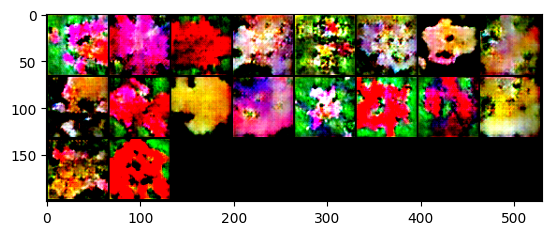

100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


epoch: 16, lossD:0.9496543022614081, lossG:5.381121857652387,lossG_fake:2.9441696625311398, lossG_real:2.4369521870196444 ,equality:0.5072174755114953


evaluate:96.2119140625,kid_mean:0.06263232976198196, kid_std:0.03636154532432556,kid_:(tensor(0.0626), tensor(0.0364))


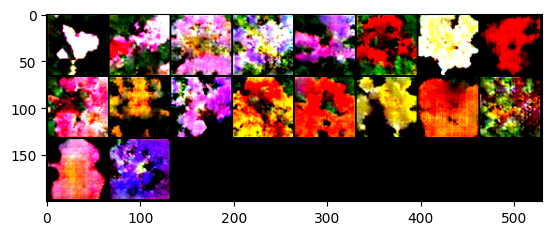

100%|██████████| 103/103 [00:09<00:00, 10.62it/s]


epoch: 17, lossD:0.936956813323845, lossG:5.299361877071047,lossG_fake:2.8481623287339812, lossG_real:2.451199545443637 ,equality:0.3969627832903444


evaluate:93.89452362060547,kid_mean:0.07181833684444427, kid_std:0.04046514257788658,kid_:(tensor(0.0718), tensor(0.0405))


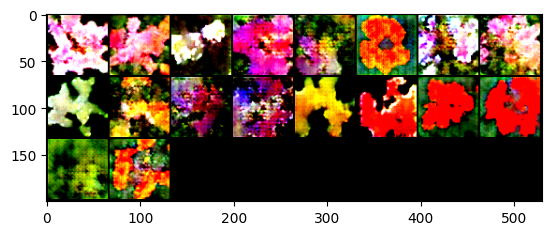

100%|██████████| 103/103 [00:09<00:00, 10.71it/s]


epoch: 18, lossD:0.7884336244134069, lossG:5.541575380899374,lossG_fake:2.976484546962294, lossG_real:2.5650908188912473 ,equality:0.41139372807104646


evaluate:95.09542083740234,kid_mean:0.07307325303554535, kid_std:0.0406552329659462,kid_:(tensor(0.0731), tensor(0.0407))


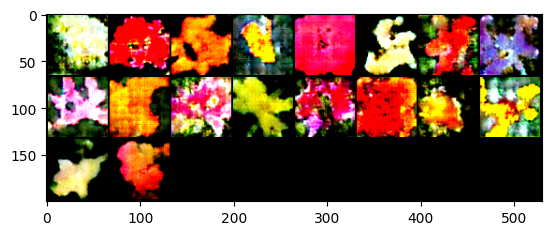

100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


epoch: 19, lossD:0.7548349074368338, lossG:5.7886585263372625,lossG_fake:3.105243508676881, lossG_real:2.6834150312594995 ,equality:0.4218284774173813


evaluate:95.07469177246094,kid_mean:0.06698969751596451, kid_std:0.04345550760626793,kid_:(tensor(0.0670), tensor(0.0435))


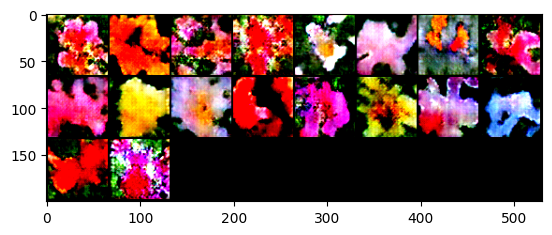

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 20, lossD:0.7275559994780901, lossG:5.818916084696945,lossG_fake:3.12246833553592, lossG_real:2.6964477584199997 ,equality:0.42602057711592023


evaluate:94.58944702148438,kid_mean:0.06839625537395477, kid_std:0.04095584526658058,kid_:(tensor(0.0684), tensor(0.0410))


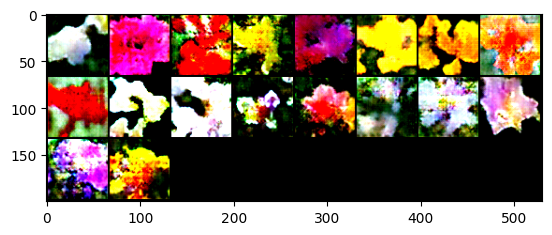

100%|██████████| 103/103 [00:09<00:00, 10.66it/s]


epoch: 21, lossD:0.7545047030576224, lossG:5.932611794147677,lossG_fake:3.161272915821631, lossG_real:2.771338882376847 ,equality:0.38993403344478406


evaluate:96.59464263916016,kid_mean:0.07264581322669983, kid_std:0.03951175510883331,kid_:(tensor(0.0726), tensor(0.0395))


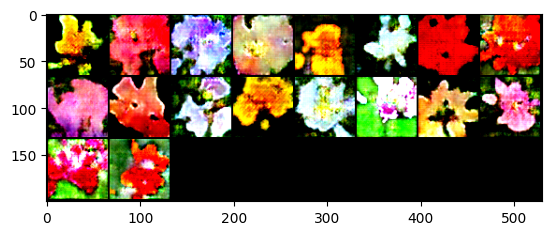

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 22, lossD:0.620510932600614, lossG:6.024240558587231,lossG_fake:3.1918534381875716, lossG_real:2.832387077576906 ,equality:0.3594663606106656


evaluate:96.46980285644531,kid_mean:0.06873886287212372, kid_std:0.03964448720216751,kid_:(tensor(0.0687), tensor(0.0396))


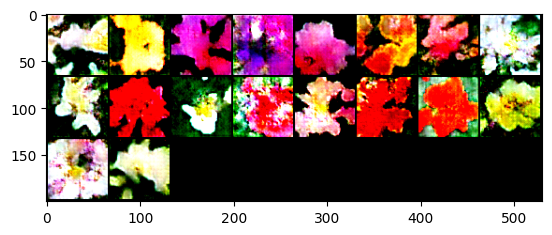

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 23, lossD:0.6184594566816265, lossG:6.20684713530309,lossG_fake:3.326601305632915, lossG_real:2.8802458389291488 ,equality:0.44635546670376636


evaluate:96.08830261230469,kid_mean:0.07046068459749222, kid_std:0.03838528320193291,kid_:(tensor(0.0705), tensor(0.0384))


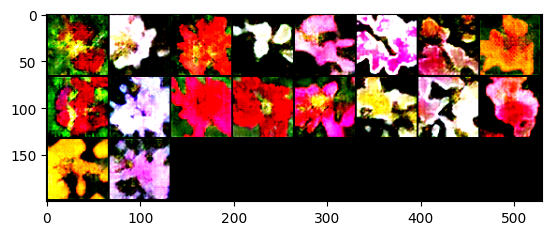

100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


epoch: 24, lossD:0.5756055816863347, lossG:6.405074008460184,lossG_fake:3.4173943406169855, lossG_real:2.98767966900057 ,equality:0.4297146716164155


evaluate:96.41553497314453,kid_mean:0.07354746758937836, kid_std:0.036503683775663376,kid_:(tensor(0.0735), tensor(0.0365))


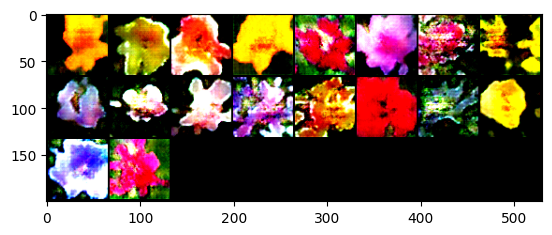

100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


epoch: 25, lossD:0.6057240531137846, lossG:6.463154116880546,lossG_fake:3.500513471445991, lossG_real:2.9626406633738176 ,equality:0.5378728080721733


evaluate:96.03755187988281,kid_mean:0.06971509009599686, kid_std:0.0402272529900074,kid_:(tensor(0.0697), tensor(0.0402))


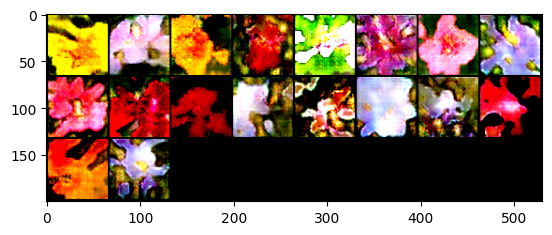

100%|██████████| 103/103 [00:09<00:00, 10.83it/s]


epoch: 26, lossD:0.5142477509176847, lossG:6.535351739346402,lossG_fake:3.443715984381518, lossG_real:3.091635753807512 ,equality:0.35208023057400606


evaluate:96.3201904296875,kid_mean:0.059652671217918396, kid_std:0.032462574541568756,kid_:(tensor(0.0597), tensor(0.0325))


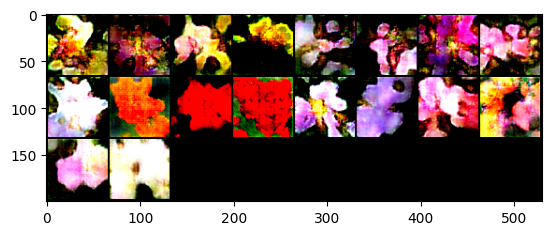

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 27, lossD:0.4773137707588742, lossG:6.577742840479878,lossG_fake:3.5193832464588497, lossG_real:3.0583595888128556 ,equality:0.46102365764599407


evaluate:97.62295532226562,kid_mean:0.06723695993423462, kid_std:0.03789138421416283,kid_:(tensor(0.0672), tensor(0.0379))


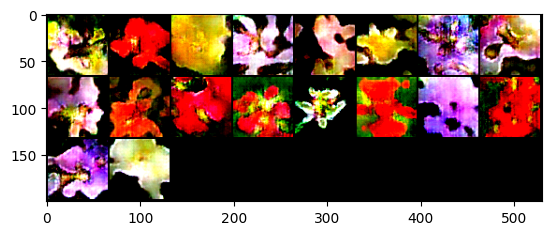

100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


epoch: 28, lossD:0.4632723131081433, lossG:6.627884966655842,lossG_fake:3.5113155795532522, lossG_real:3.1165693790009876 ,equality:0.3947462005522646


evaluate:96.62384033203125,kid_mean:0.06819337606430054, kid_std:0.03916683793067932,kid_:(tensor(0.0682), tensor(0.0392))


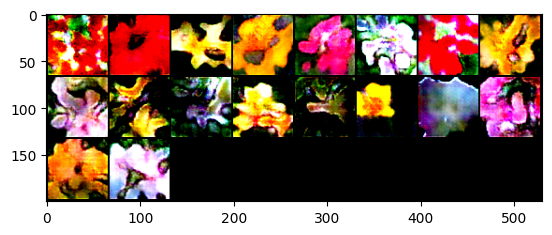

100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


epoch: 29, lossD:0.38337054062019854, lossG:6.73222072379103,lossG_fake:3.5789242832406054, lossG_real:3.1532964451799117 ,equality:0.4256278380606937


evaluate:94.89440155029297,kid_mean:0.06065823882818222, kid_std:0.037805456668138504,kid_:(tensor(0.0607), tensor(0.0378))


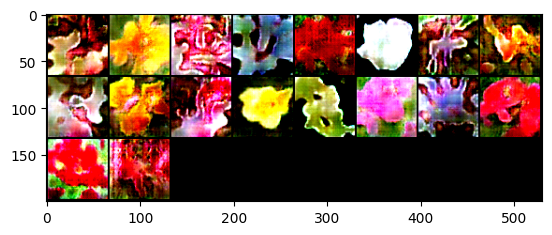

100%|██████████| 103/103 [00:09<00:00, 10.68it/s]


epoch: 30, lossD:0.3890935522549361, lossG:6.993001021227791,lossG_fake:3.7503090414028724, lossG_real:3.242691979824918 ,equality:0.5076170615779545


evaluate:95.29937744140625,kid_mean:0.06505194306373596, kid_std:0.035727836191654205,kid_:(tensor(0.0651), tensor(0.0357))


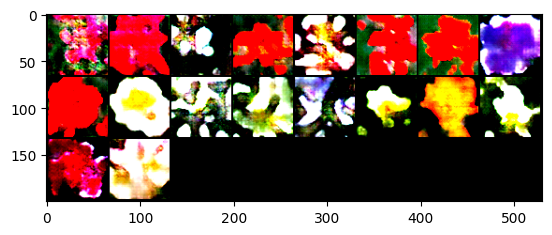

100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


epoch: 31, lossD:0.31716736239715687, lossG:7.206451485457929,lossG_fake:3.8276979946395726, lossG_real:3.378753504706818 ,equality:0.4489444899327548


evaluate:94.98445129394531,kid_mean:0.07112522423267365, kid_std:0.03805655241012573,kid_:(tensor(0.0711), tensor(0.0381))


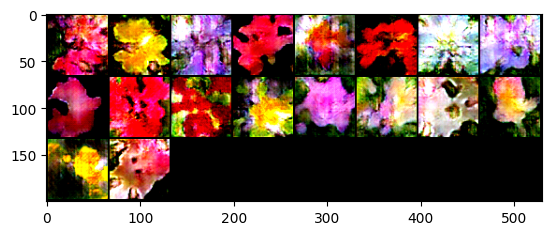

100%|██████████| 103/103 [00:09<00:00, 10.76it/s]


epoch: 32, lossD:0.3588643657423339, lossG:7.318243281355182,lossG_fake:3.9638524113349543, lossG_real:3.3543908381925047 ,equality:0.6094615731424495


evaluate:94.82917785644531,kid_mean:0.07603082805871964, kid_std:0.046963512897491455,kid_:(tensor(0.0760), tensor(0.0470))


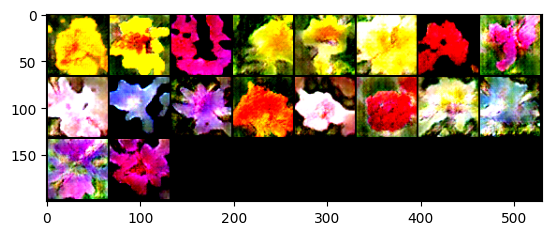

100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


epoch: 33, lossD:0.41357968375086784, lossG:7.416098168752725,lossG_fake:4.066481641195352, lossG_real:3.3496165292934306 ,equality:0.7168651119019218


evaluate:94.6810302734375,kid_mean:0.07023186981678009, kid_std:0.0416216179728508,kid_:(tensor(0.0702), tensor(0.0416))


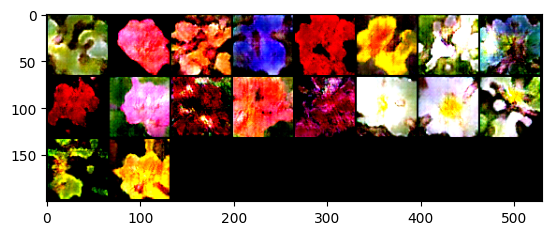

100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


epoch: 34, lossD:0.4042748456404915, lossG:7.216914343602449,lossG_fake:3.8594950854199603, lossG_real:3.3574192685988344 ,equality:0.5020758168211259


evaluate:95.53387451171875,kid_mean:0.0693025141954422, kid_std:0.0393325574696064,kid_:(tensor(0.0693), tensor(0.0393))


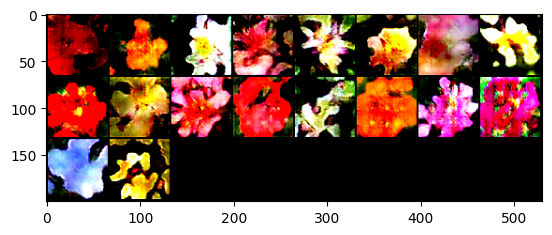

100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


epoch: 35, lossD:0.3860036269806832, lossG:7.332110275342626,lossG_fake:3.940360418801169, lossG_real:3.391749854516057 ,equality:0.548610564285112


evaluate:96.01689910888672,kid_mean:0.07328058779239655, kid_std:0.039958931505680084,kid_:(tensor(0.0733), tensor(0.0400))


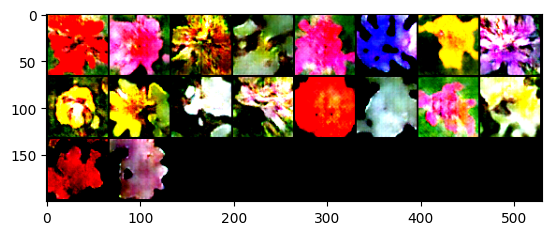

100%|██████████| 103/103 [00:09<00:00, 10.63it/s]


epoch: 36, lossD:0.36856085405621714, lossG:7.366440573942314,lossG_fake:3.902061090886014, lossG_real:3.4643794680104674 ,equality:0.4376816228755467


evaluate:96.87619018554688,kid_mean:0.06691214442253113, kid_std:0.0446602888405323,kid_:(tensor(0.0669), tensor(0.0447))


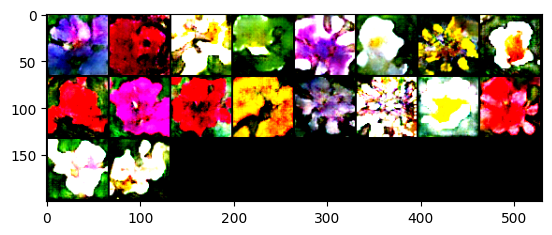

100%|██████████| 103/103 [00:09<00:00, 10.89it/s]


epoch: 37, lossD:0.42064469173839947, lossG:7.61056309764825,lossG_fake:4.104170588613714, lossG_real:3.5063925084558507 ,equality:0.5977780801578634


evaluate:95.6178970336914,kid_mean:0.07279197871685028, kid_std:0.043384529650211334,kid_:(tensor(0.0728), tensor(0.0434))


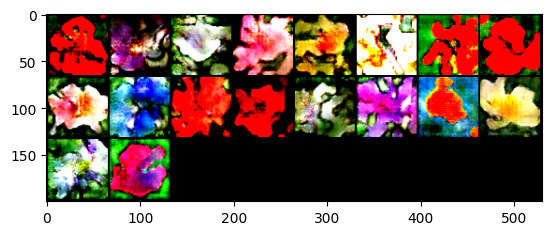

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 38, lossD:0.2987742501410466, lossG:7.4209341169561,lossG_fake:3.9696683281833685, lossG_real:3.4512657876153594 ,equality:0.518402540568009


evaluate:94.878173828125,kid_mean:0.07297664880752563, kid_std:0.04094734042882919,kid_:(tensor(0.0730), tensor(0.0409))


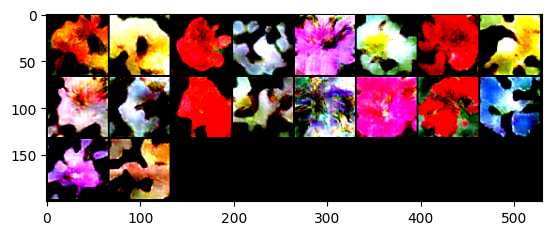

100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


epoch: 39, lossD:0.30818810105974814, lossG:7.5264709852274185,lossG_fake:4.022130421064432, lossG_real:3.504340544487666 ,equality:0.5177898765767659


evaluate:92.64191436767578,kid_mean:0.07000575214624405, kid_std:0.04590864107012749,kid_:(tensor(0.0700), tensor(0.0459))


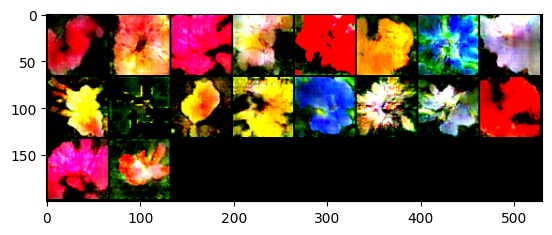

100%|██████████| 103/103 [00:09<00:00, 10.63it/s]


epoch: 40, lossD:0.32095806698486645, lossG:7.56072182794219,lossG_fake:3.988013927074312, lossG_real:3.5727078636873117 ,equality:0.41530606338700027


evaluate:91.64273834228516,kid_mean:0.06668254733085632, kid_std:0.03924230858683586,kid_:(tensor(0.0667), tensor(0.0392))


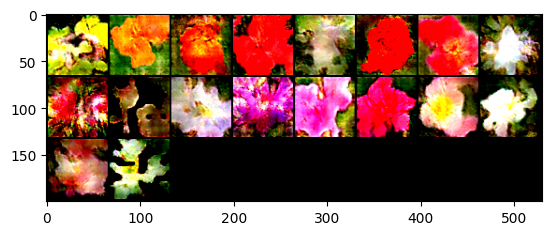

100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


epoch: 41, lossD:0.35440190277487327, lossG:7.767864495805166,lossG_fake:4.199378769374588, lossG_real:3.5684857345321803 ,equality:0.630893034842408


evaluate:92.7404556274414,kid_mean:0.0727873295545578, kid_std:0.04172420874238014,kid_:(tensor(0.0728), tensor(0.0417))


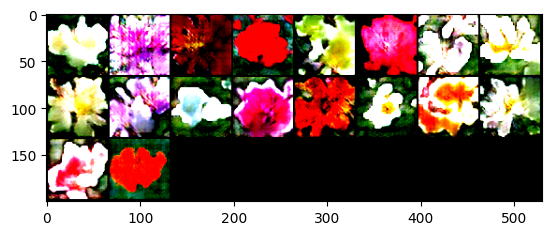

100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


epoch: 42, lossD:0.31204124341167294, lossG:7.6259794883357666,lossG_fake:4.116447746175007, lossG_real:3.5095317329017863 ,equality:0.6069160132732208


evaluate:90.65324401855469,kid_mean:0.06431262940168381, kid_std:0.039716437458992004,kid_:(tensor(0.0643), tensor(0.0397))


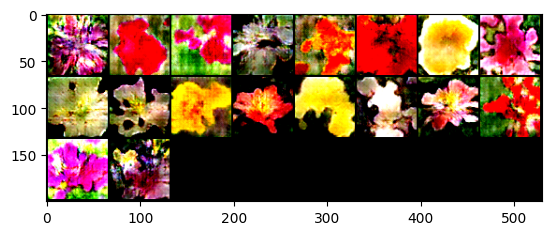

100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


epoch: 43, lossD:0.3494974889439865, lossG:7.700825885661597,lossG_fake:4.124234211097643, lossG_real:3.5765916410001735 ,equality:0.5476425700974694


evaluate:90.23574829101562,kid_mean:0.0720265805721283, kid_std:0.04218907654285431,kid_:(tensor(0.0720), tensor(0.0422))


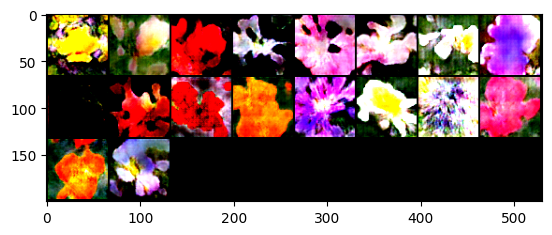

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 44, lossD:0.31857769585494855, lossG:7.737568901580515,lossG_fake:4.1408714079162445, lossG_real:3.5966974962683556 ,equality:0.544173911647889


evaluate:90.82665252685547,kid_mean:0.06956001371145248, kid_std:0.041305650025606155,kid_:(tensor(0.0696), tensor(0.0413))


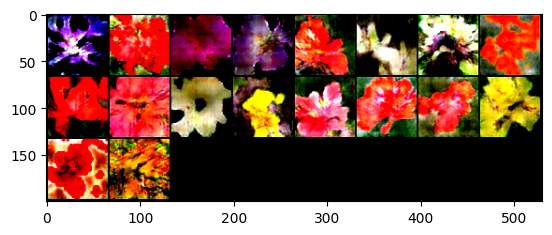

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 45, lossD:0.2995159843375961, lossG:7.851339742975328,lossG_fake:4.142681082475533, lossG_real:3.7086586929062038 ,equality:0.4340223895693289


evaluate:90.48249053955078,kid_mean:0.06909023970365524, kid_std:0.038913678377866745,kid_:(tensor(0.0691), tensor(0.0389))


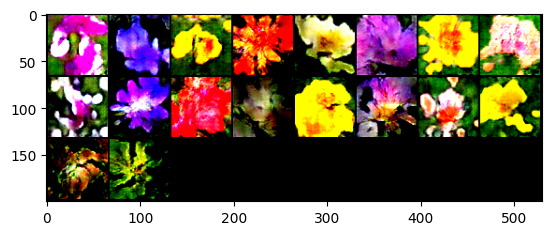

100%|██████████| 103/103 [00:10<00:00, 10.05it/s]


epoch: 46, lossD:0.2737772993345573, lossG:7.756842594702267,lossG_fake:4.089642378311713, lossG_real:3.6672002207306984 ,equality:0.42244215758101467


evaluate:89.67508697509766,kid_mean:0.06992196291685104, kid_std:0.044863492250442505,kid_:(tensor(0.0699), tensor(0.0449))


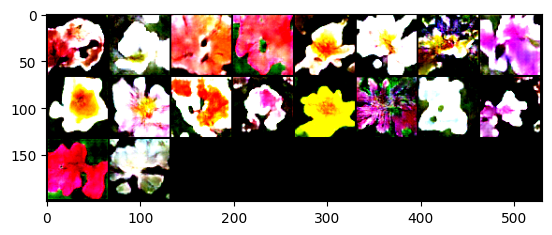

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 47, lossD:0.28126924678466275, lossG:7.8003173198514775,lossG_fake:4.14581036567688, lossG_real:3.654506945494309 ,equality:0.4913034201825708


evaluate:90.48638153076172,kid_mean:0.06588015705347061, kid_std:0.037646666169166565,kid_:(tensor(0.0659), tensor(0.0376))


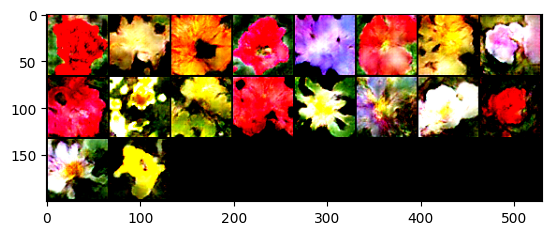

100%|██████████| 103/103 [00:10<00:00, 10.08it/s]


epoch: 48, lossD:0.31855284221904373, lossG:7.86352282125973,lossG_fake:4.19759986122835, lossG_real:3.665922921259426 ,equality:0.5316769399689241


evaluate:90.34964752197266,kid_mean:0.059156354516744614, kid_std:0.03867289051413536,kid_:(tensor(0.0592), tensor(0.0387))


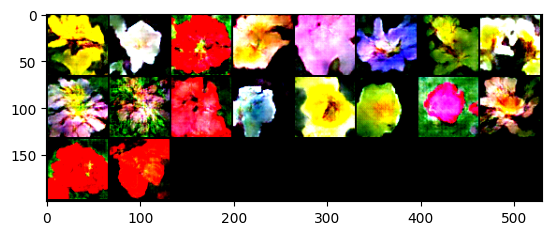

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 49, lossD:0.259412026701911, lossG:7.889932817625768,lossG_fake:4.156772720003591, lossG_real:3.733160074474742 ,equality:0.4236126455288489


evaluate:89.49557495117188,kid_mean:0.07786981761455536, kid_std:0.04468270391225815,kid_:(tensor(0.0779), tensor(0.0447))


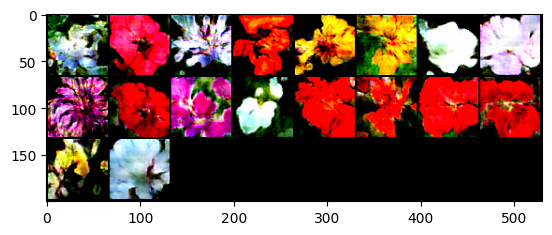

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

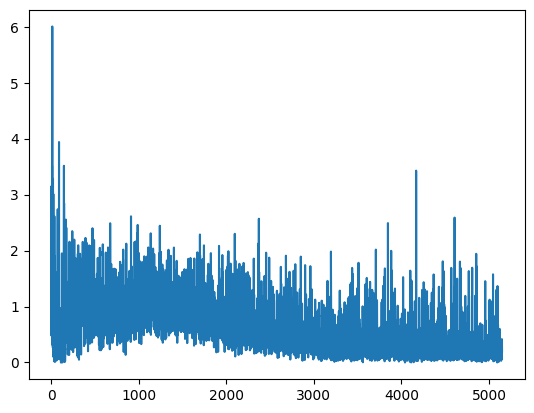

In [45]:
plt.plot(raw_lossesD)

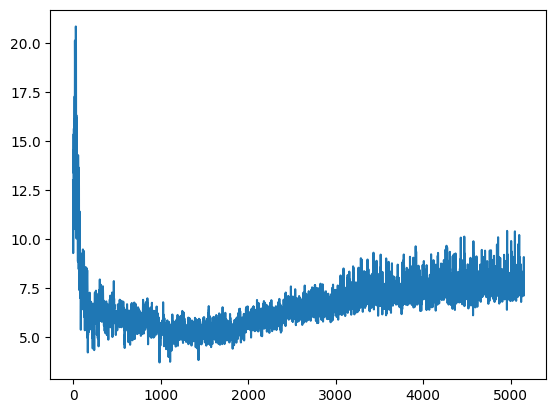

In [46]:
plt.plot(raw_lossesG)

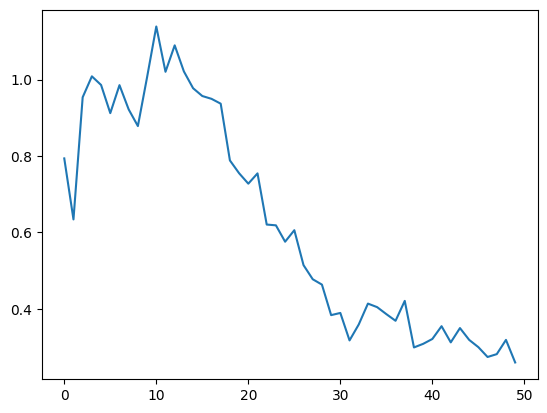

In [47]:
plt.plot(lossesD)

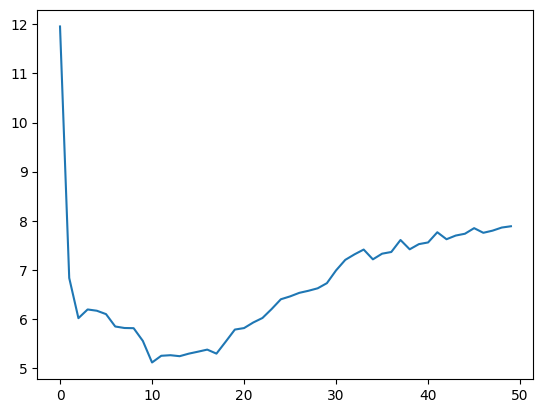

In [48]:
plt.plot(lossesG)

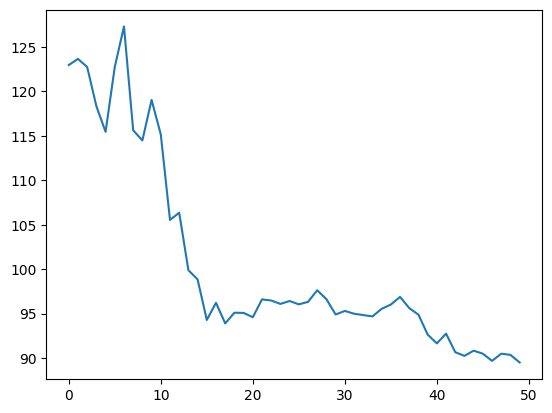

In [49]:
plt.plot(fid_)

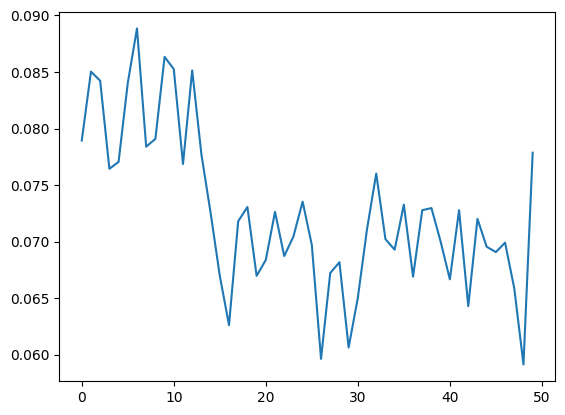

In [50]:
plt.plot(kid_mean_)

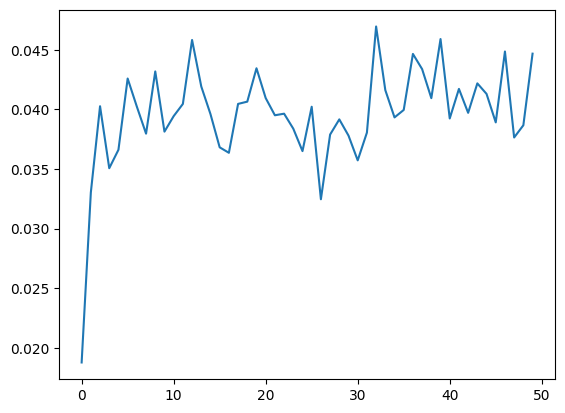

In [51]:
plt.plot(kid_std_)

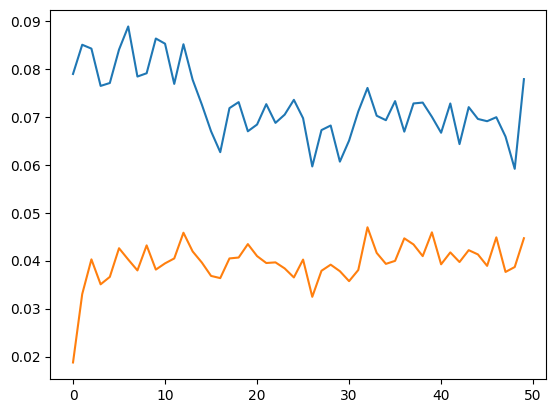

In [52]:
plt.plot(kid_score)

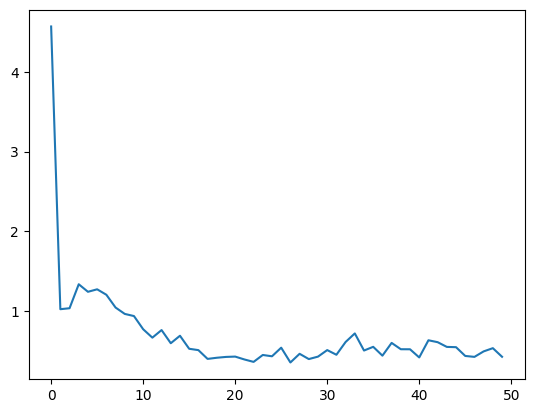

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0721), tensor(0.0455))